In [1]:
#!jt -t chesterish  # set given theme
#!jt -r # reset default theme

# Southern Women Dataset
## An illustration of agglomerative clustering in bipartite networks
### Adrián Fernández Cid

## Outline
### 1. Data and unipartite projection
### 2. Hierarchical clustering


## 1. Data and unipartite projection

The Southern Women dataset is a bipartite network of 18 women linked to 14 different social events only if they attended the given event. It is a popular dataset for testing clustering methods in bipartite networks, as there are two distinct communities of women, each preferring one of two classes of social event.

Data from http://casos.cs.cmu.edu/computational_tools/datasets/external/davis/index2.html.

Let us load and check the data;

In [19]:
import xml.etree.ElementTree as ET
tree = ET.parse('../data/SouthernWomen.xml')
root = tree.getroot()

In [20]:
#recursively check all (*) elements in tree and print 
#their tag and atribute
for element in root.iter('*'): 
    print(element.tag, element.attrib)

DynamicMetaNetwork {'id': 'davis'}
MetaNetwork {'id': 'davis'}
nodes {}
nodeclass {'type': 'Agent', 'id': 'agent'}
node {'id': 'EVELYN'}
node {'id': 'LAURA'}
node {'id': 'THERESA'}
node {'id': 'BRENDA'}
node {'id': 'CHARLOTTE'}
node {'id': 'FRANCES'}
node {'id': 'ELEANOR'}
node {'id': 'PEARL'}
node {'id': 'RUTH'}
node {'id': 'VERNE'}
node {'id': 'MYRNA'}
node {'id': 'KATHERINE'}
node {'id': 'SYLVIA'}
node {'id': 'NORA'}
node {'id': 'HELEN'}
node {'id': 'DOROTHY'}
node {'id': 'OLIVIA'}
node {'id': 'FLORA'}
nodeclass {'type': 'Event', 'id': 'event'}
node {'id': 'E1'}
node {'id': 'E2'}
node {'id': 'E3'}
node {'id': 'E4'}
node {'id': 'E5'}
node {'id': 'E6'}
node {'id': 'E7'}
node {'id': 'E8'}
node {'id': 'E9'}
node {'id': 'E10'}
node {'id': 'E11'}
node {'id': 'E12'}
node {'id': 'E13'}
node {'id': 'E14'}
networks {}
network {'sourceType': 'Agent', 'source': 'agent', 'targetType': 'Event', 'target': 'event', 'id': 'agent x event'}
link {'source': 'EVELYN', 'target': 'E1'}
link {'source': 'EV

Recover nodes (women and events):

In [21]:
nodes = []
for node in root.iter('node'): 
    nodes.append(node.attrib["id"])

In [22]:
print(nodes)
women = nodes[:18]
events = nodes[18:]

['EVELYN', 'LAURA', 'THERESA', 'BRENDA', 'CHARLOTTE', 'FRANCES', 'ELEANOR', 'PEARL', 'RUTH', 'VERNE', 'MYRNA', 'KATHERINE', 'SYLVIA', 'NORA', 'HELEN', 'DOROTHY', 'OLIVIA', 'FLORA', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14']


Define a dictionary containing all events each of the women attended:

In [23]:
woman2event = {w:[] for w in women}
for link in root.iter('link'): 
    source = link.attrib["source"]
    target = link.attrib["target"]
    woman2event[source].append(target)
woman2event

{'EVELYN': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E9'],
 'LAURA': ['E1', 'E2', 'E3', 'E5', 'E6', 'E7', 'E8'],
 'THERESA': ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9'],
 'BRENDA': ['E1', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'],
 'CHARLOTTE': ['E3', 'E4', 'E5', 'E7'],
 'FRANCES': ['E3', 'E5', 'E6', 'E8'],
 'ELEANOR': ['E5', 'E6', 'E7', 'E8'],
 'PEARL': ['E6', 'E8', 'E9'],
 'RUTH': ['E5', 'E7', 'E8', 'E9'],
 'VERNE': ['E7', 'E8', 'E9', 'E12'],
 'MYRNA': ['E8', 'E9', 'E10', 'E12'],
 'KATHERINE': ['E8', 'E9', 'E10', 'E12', 'E13', 'E14'],
 'SYLVIA': ['E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14'],
 'NORA': ['E6', 'E7', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14'],
 'HELEN': ['E7', 'E8', 'E10', 'E11', 'E12'],
 'DOROTHY': ['E8', 'E9'],
 'OLIVIA': ['E9', 'E11'],
 'FLORA': ['E9', 'E11']}

Define a dictionary containing a binary feature vector per event, the vector corresponding to the attendance value (yes:1, no:0) of each woman. **From a conceptual (social) perspective, it is more interesting to do this for women rather than for events (even if the two communities are there in either case): change it in the future.**

In [24]:
import numpy as np

n_women = len(women)
event2vect = {e:[0]*n_women for e in events}
for e in events:
    for i, w in enumerate(women):
        if e in woman2event[w]:
            event2vect[e][i] = 1
event2vect
            

{'E1': [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E2': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E3': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E4': [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E5': [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'E6': [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'E7': [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
 'E8': [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 'E9': [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
 'E10': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
 'E11': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
 'E12': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 'E13': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 'E14': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]}

Bipartite women-events network:

In [25]:
import networkx as nx

B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(events, bipartite=0)
B.add_nodes_from(women, bipartite=1)

#add edges
for link in root.iter('link'): 
    source = link.attrib["source"]
    target = link.attrib["target"]
    B.add_edge(source, target)

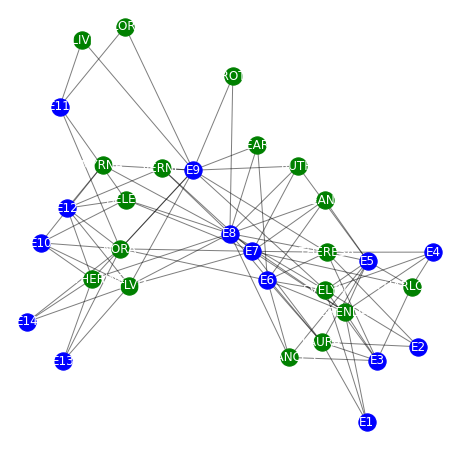

In [26]:
import matplotlib.pyplot as plt

pos = nx.fruchterman_reingold_layout(B);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(women, pos, node_size=300, node_color="green");
nx.draw_networkx_nodes(events, pos, node_size=300, node_color="blue");
nx.draw_networkx_edges(B, pos, alpha=0.500);
nx.draw_networkx_labels(B, pos, font_color="white");
plt.show()

Unipartite events network (projection of the above):

In [27]:
E = nx.Graph()
E.add_nodes_from(events)
n_events = len(events)

#add edges
for i, ei in enumerate(events):
    for w_idx in range(n_women):
        if event2vect[ei][w_idx]==1:
            for j in range(i+1, n_events):
                if event2vect[events[j]][w_idx]==1:
                    E.add_edge(ei, events[j])

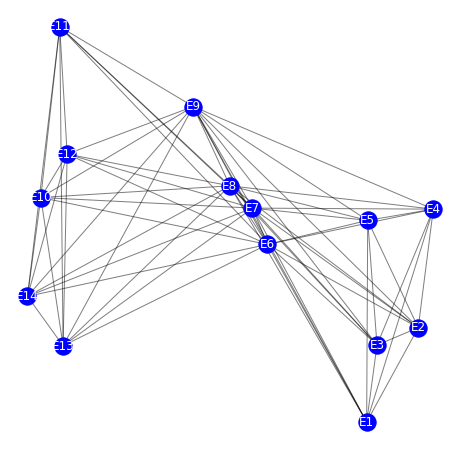

In [28]:
#pos = nx.fruchterman_reingold_layout(B);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(events, pos, node_size=300, node_color="blue");
nx.draw_networkx_edges(E, pos, alpha=0.500);
nx.draw_networkx_labels(E, pos, font_color="white");
plt.show()

## 2. Hierarchical clustering

First, we define the distance matrix between nodes (events). To do so, we consider their pairwise phi-correlation (using the previously defined dictionary **event2vect**), which we later turn into an Euclidean distance.

In [29]:
from sklearn.metrics import matthews_corrcoef

#build condensed distance matrix
phi = []
n_events = len(events)
for i, ei in enumerate(events):
    vec_ei = event2vect[ei]
    for j in range(i+1, n_events):
        vec_ej = event2vect[events[j]]  
        phi.append(matthews_corrcoef(vec_ei, vec_ej))
        #to check correlations are actually symmetric
        #print(matthews_corrcoef(vec_i, vec_j)
        #      , matthews_corrcoef(vec_j,vec_i))
        
#the expected length is n(n-1)/2
print(len(phi), 14*13/2)
#turn correlations to Euclidean distances (the phi are somewhat like the cosine)
d = np.sqrt(2*(1-np.array(phi)))
d.shape

91 91.0


(91,)

We are now ready to apply hierarchical clustering. The scipy method gives:

(13, 4)


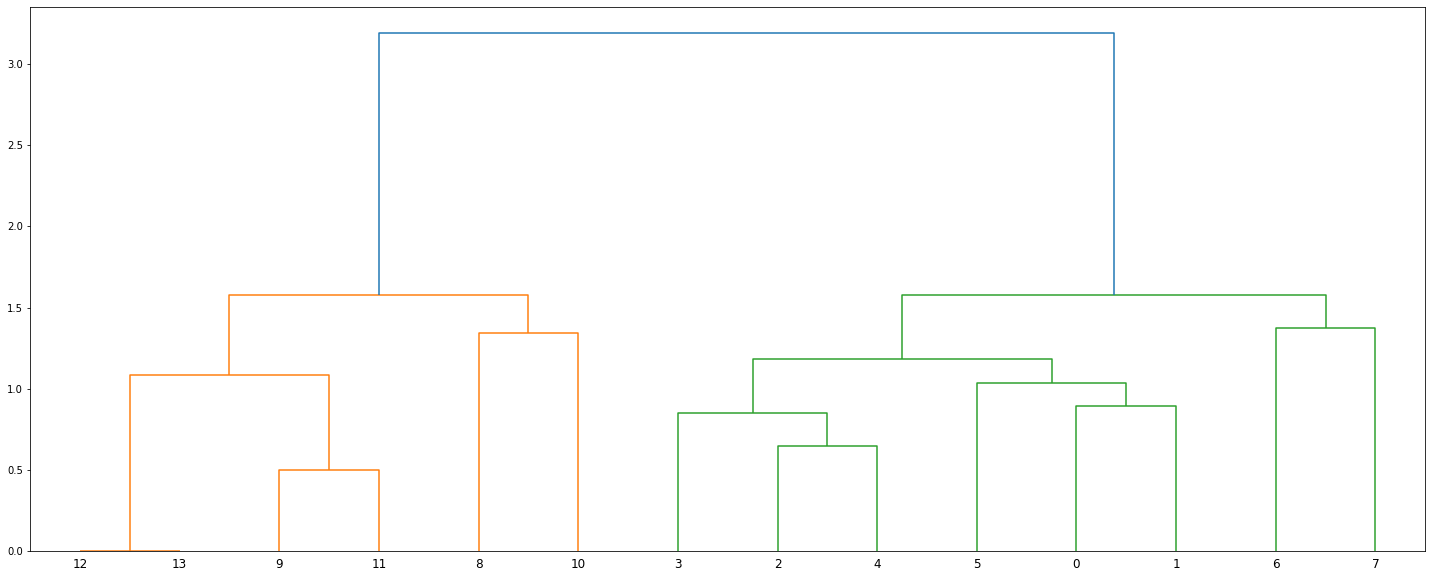

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage

z_sc = linkage(d, 'ward')
print(z_sc.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_sc)
plt.show()

In [34]:
z_sc

array([[12.        , 13.        ,  0.        ,  2.        ],
       [ 9.        , 11.        ,  0.49586688,  2.        ],
       [ 2.        ,  4.        ,  0.64719485,  2.        ],
       [ 3.        , 16.        ,  0.84989525,  3.        ],
       [ 0.        ,  1.        ,  0.89442719,  2.        ],
       [ 5.        , 18.        ,  1.03279556,  3.        ],
       [14.        , 15.        ,  1.08163138,  4.        ],
       [17.        , 19.        ,  1.18065865,  6.        ],
       [ 8.        , 10.        ,  1.3457406 ,  2.        ],
       [ 6.        ,  7.        ,  1.3713049 ,  2.        ],
       [20.        , 22.        ,  1.57691355,  6.        ],
       [21.        , 23.        ,  1.57811673,  8.        ],
       [24.        , 25.        ,  3.19271228, 14.        ]])

While our method gives:

In [32]:
#for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

(13, 4)


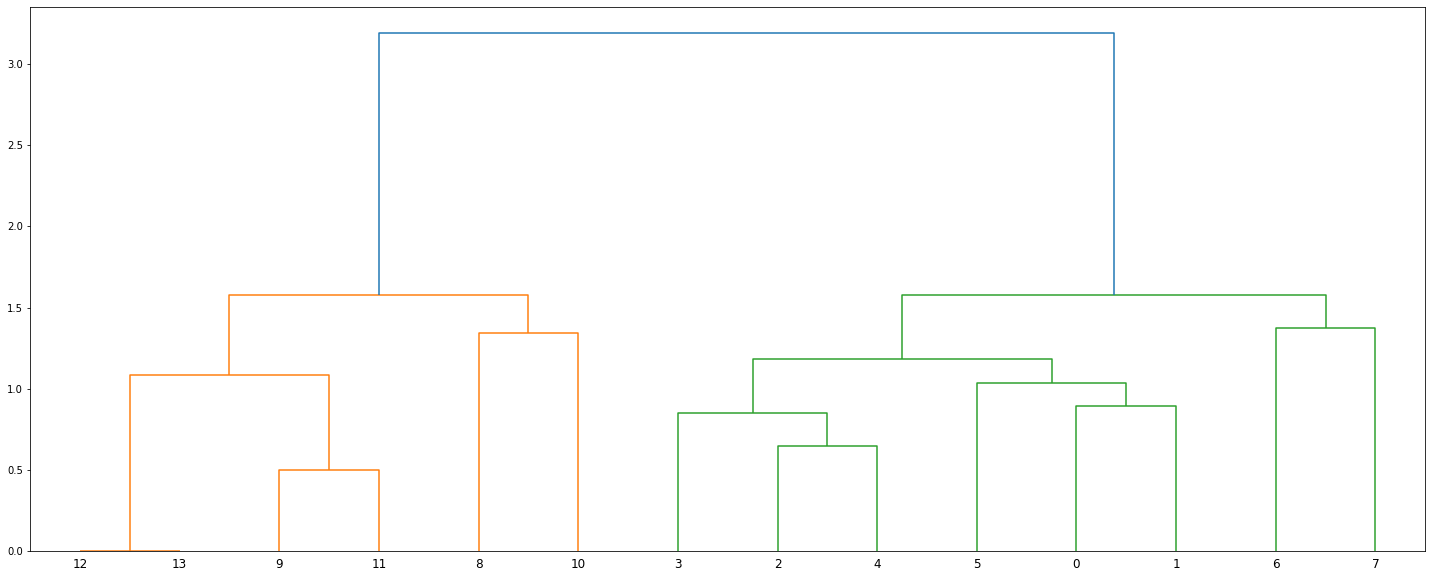

In [33]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z = agglomerative_clustering(d, method='ward')
print(z.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z)
plt.show()

In [35]:
z

array([[12.        , 13.        ,  0.        ,  2.        ],
       [ 9.        , 11.        ,  0.49586688,  2.        ],
       [ 2.        ,  4.        ,  0.64719485,  2.        ],
       [ 3.        , 16.        ,  0.84989525,  3.        ],
       [ 0.        ,  1.        ,  0.89442719,  2.        ],
       [ 5.        , 18.        ,  1.03279556,  3.        ],
       [14.        , 15.        ,  1.08163138,  4.        ],
       [17.        , 19.        ,  1.18065865,  6.        ],
       [ 8.        , 10.        ,  1.3457406 ,  2.        ],
       [ 6.        ,  7.        ,  1.3713049 ,  2.        ],
       [20.        , 22.        ,  1.57691355,  6.        ],
       [21.        , 23.        ,  1.57811673,  8.        ],
       [24.        , 25.        ,  3.19271228, 14.        ]])

In [36]:
np.isclose(z,z_sc)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

Great! Our adaptation of the scipy method is validated. The results are not exactly the same as scipy's for methods that do not use the **nn_chain** algorithm (like "centroids"), but that is expected.

Let's now see what we get when using the polarisation distance, i.e.

$$d_{u,v} = d^c_{u,v}( \pi_u^{1+\alpha}\pi_v + \pi_v^{1+\alpha}\pi_u)$$

where $\alpha \in (0,1.6]$, $\pi_i$ is the size of cluster $i$ and $d^c_{u,v}$ is the centroid distance between $u$ and $v$, as the clustering criterion:

(13, 4)


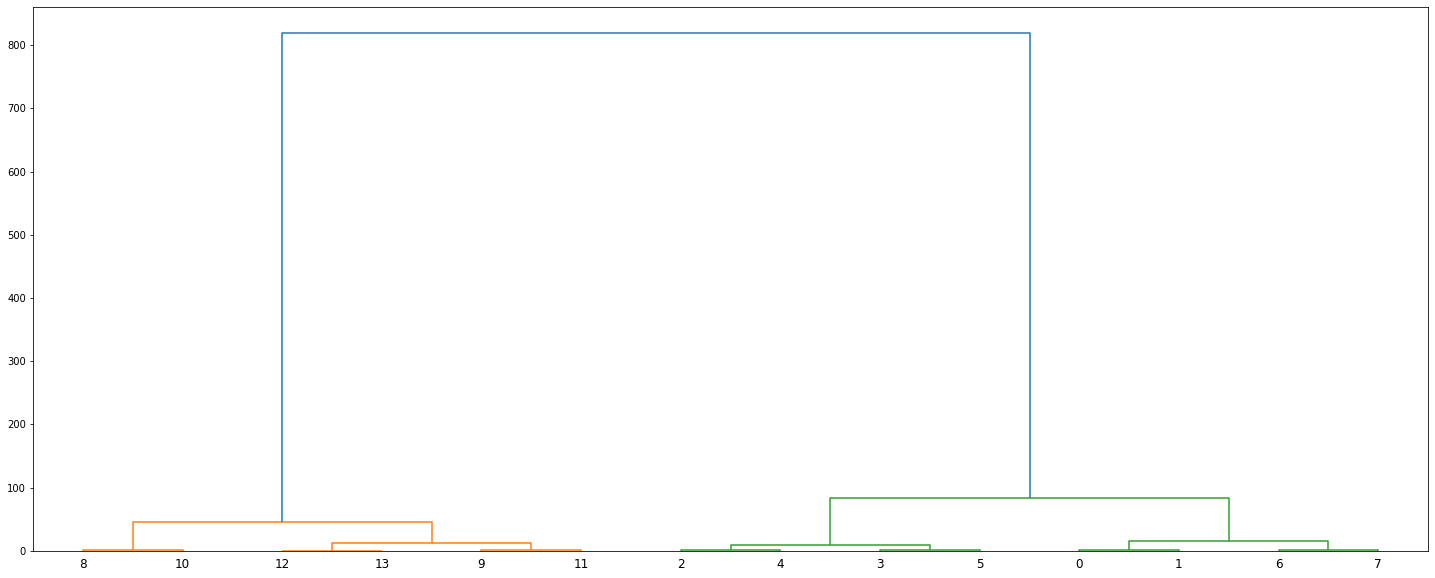

In [37]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z = agglomerative_clustering(d, method='polarisation', alpha=1)
print(z.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z)
plt.show()

In [40]:
#have to change np print option by activating suppression;
#otherwise everything appears in lengthy scientific notation due to large distance (819)
np.set_printoptions(suppress=True)
z

array([[ 12.        ,  13.        ,   0.        ,   2.        ],
       [  9.        ,  11.        ,   0.49586688,   2.        ],
       [  2.        ,   4.        ,   0.64719485,   2.        ],
       [  0.        ,   1.        ,   0.89442719,   2.        ],
       [  3.        ,   5.        ,   1.15871665,   2.        ],
       [  8.        ,  10.        ,   1.3457406 ,   2.        ],
       [  6.        ,   7.        ,   1.3713049 ,   2.        ],
       [ 16.        ,  18.        ,   9.20740878,   4.        ],
       [ 14.        ,  15.        ,  12.23726215,   4.        ],
       [ 17.        ,  20.        ,  15.92651118,   4.        ],
       [ 19.        ,  22.        ,  46.35160282,   6.        ],
       [ 21.        ,  23.        ,  83.12085234,   8.        ],
       [ 24.        ,  25.        , 819.32735884,  14.        ]])

Looks ok! Note that the last distance given in the linkage matrix, $819$, is the actual polarisation of the system (up to the normalisation constant $K$) when only two clusters (24 and 25) are left. Since this method is obviously not available in the scipy function, we cannot compare them in this case.